In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U xgboost

Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (0.90)


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [3]:
!pip install pandas-profiling

In [4]:
!pip install scikit-plot

In [5]:
!python -m pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.2.3)


- 金融风控问题的正负样本一般在10:1到30:1（一开始是10:1，到后面是20:1甚至30:1）

In [0]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline

# 定义target

In [0]:
df = pd.read_csv('/content/drive/My Drive/风控/LoanStats_2016Q3 (1).csv', skiprows = 1, low_memory = False)

In [8]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_il_6m,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,NaN,NaN,15000.0,15000.0,15000.0,36 months,13.99%,512.60,C,C3,Fiscal Director,2 years,RENT,55000.0,Not Verified,Sep-2016,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,372xx,TN,23.78,1.0,Jan-1996,0.0,7.0,NaN,22.0,0.0,21345.0,57.8%,43.0,f,10598.90,10598.90,5577.480000,5577.48,...,4.0,4.0,0.0,4.0,7.0,22.0,7.0,0.0,5.0,9.0,6.0,7.0,25.0,11.0,18.0,9.0,22.0,0.0,0.0,0.0,5.0,100.0,33.3,0.0,0.0,147587.0,140492.0,30200.0,108587.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2600.0,2600.0,2600.0,36 months,8.99%,82.67,B,B1,Loaner Coordinator,3 years,RENT,35000.0,Source Verified,Sep-2016,Fully Paid,n,NaN,NaN,moving,Moving and relocation,970xx,OR,6.73,0.0,Sep-2009,0.0,NaN,NaN,14.0,0.0,720.0,1.4%,24.0,w,0.00,0.00,2662.590238,2662.59,...,13.0,13.0,0.0,24.0,NaN,1.0,NaN,0.0,4.0,5.0,6.0,8.0,14.0,7.0,10.0,5.0,14.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,73227.0,19497.0,50200.0,20527.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,32200.0,32200.0,32200.0,60 months,21.49%,880.02,D,D5,warehouse/supervisor,10+ years,MORTGAGE,65000.0,Not Verified,Sep-2016,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,923xx,CA,11.71,0.0,Nov-1992,1.0,NaN,87.0,17.0,1.0,11987.0,48.1%,34.0,w,0.00,0.00,35770.812746,35770.81,...,3.0,3.0,3.0,32.0,NaN,0.0,NaN,0.0,3.0,5.0,5.0,10.0,7.0,14.0,24.0,5.0,17.0,0.0,0.0,0.0,2.0,100.0,40.0,1.0,0.0,199969.0,24934.0,13900.0,15886.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10000.0,10000.0,10000.0,36 months,11.49%,329.72,B,B5,Teacher,10+ years,OWN,55900.0,Not Verified,Sep-2016,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,780xx,TX,26.21,0.0,Jul-1987,2.0,NaN,NaN,15.0,0.0,17209.0,53.1%,62.0,w,8021.56,8021.56,2664.990000,2664.99,...,1.0,1.0,1.0,1.0,NaN,2.0,NaN,0.0,2.0,8.0,3.0,7.0,28.0,13.0,33.0,8.0,15.0,0.0,0.0,0.0,6.0,100.0,66.7,0.0,0.0,68831.0,38085.0,13500.0,36431.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,6000.0,6000.0,6000.0,36 months,13.49%,203.59,C,C2,SERVICE MGR,5 years,RENT,33000.0,Not Verified,Sep-2016,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,232xx,VA,19.05,0.0,Jul-1996,0.0,NaN,NaN,3.0,0.0,4576.0,95.3%,11.0,f,4718.18,4718.18,1791.840000,1791.84,...,44.0,8.0,0.0,118.0,NaN,NaN,NaN,0.0,2.0,2.0,2.0,6.0,2.0,2.0,9.0,2.0,3.0,0.0,0.0,0.0,1.0,100.0,100.0,0.0,0.0,17500.0,15393.0,4800.0,12700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_il_6m', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog'],
      dtype='object', length=122)

In [10]:
df.shape

(99122, 122)

In [0]:
df_clean = df.copy()

In [12]:
df_clean.loan_status.value_counts()

Current               79445
Fully Paid            13066
Charged Off            2502
Late (31-120 days)     2245
In Grace Period        1407
Late (16-30 days)       454
Default                   1
Name: loan_status, dtype: int64

In [0]:
df_clean.drop('id', axis = 1, inplace = True)

In [0]:
df_clean.drop('member_id', axis = 1, inplace = True)

In [0]:
df_clean.dropna(axis = 0, how = 'all', inplace = True)

In [0]:
df_clean.dropna(axis = 1, how = 'all', inplace = True)

In [17]:
df_clean.loan_status.replace('Fully Paid', 0, inplace = True)
df_clean.loan_status.replace('Current', 0, inplace = True)
df_clean.loan_status.replace('Late (16-30 days)', 1, inplace = True)
df_clean.loan_status.replace('Late (31-120 days)', 1, inplace = True)
df_clean.loan_status.replace('Charged Off', 1, inplace = True)
df_clean.loan_status.replace('In Grace Period', np.nan, inplace = True)
df_clean.loan_status.replace('Default', np.nan, inplace = True)
df_clean.loan_status.value_counts(dropna = False)

0.0    92511
1.0     5201
NaN     1408
Name: loan_status, dtype: int64

In [0]:
df_clean.dropna(subset = ['loan_status'], inplace = True)
y = df_clean.loan_status
df_clean.drop('loan_status', axis = 1, inplace = True)

# 特征查看和预处理
## 处理缺失50%的数据

In [19]:
missing_col = []
missing_col_nums = []
for col in df_clean.columns:
    missing_nums = round(len(df_clean[df_clean[col].isnull()].index) / len(df_clean), 5)
    if missing_nums:
        missing_col.append(col)
        missing_col_nums.append((col, missing_nums))
for i in sorted(missing_col_nums, key = lambda x: x[1], reverse = True):
    print(i)
    if i[1] >0.5:
        missing_col.remove(i[0])
        missing_col_nums.remove(i)
        df_clean.drop(i[0], axis = 1, inplace = True)

('desc', 0.99994)
('annual_inc_joint', 0.99483)
('dti_joint', 0.99483)
('verification_status_joint', 0.99483)
('mths_since_last_record', 0.80075)
('mths_since_recent_bc_dlq', 0.73808)
('mths_since_last_major_derog', 0.70434)
('mths_since_recent_revol_delinq', 0.63154)
('mths_since_last_delinq', 0.46277)
('next_pymnt_d', 0.15933)
('il_util', 0.13812)
('mths_since_recent_inq', 0.10012)
('emp_title', 0.0605)
('emp_length', 0.05981)
('title', 0.05447)
('num_tl_120dpd_2m', 0.03476)
('mths_since_rcnt_il', 0.0268)
('mo_sin_old_il_acct', 0.0268)
('bc_util', 0.0115)
('percent_bc_gt_75', 0.01119)
('bc_open_to_buy', 0.01114)
('mths_since_recent_bc', 0.01058)
('last_pymnt_d', 0.00132)
('revol_util', 0.00061)
('all_util', 6e-05)
('last_credit_pull_d', 5e-05)


## 剔除贷后数据

In [0]:
df_clean.drop(['out_prncp','out_prncp_inv','total_pymnt',
         'total_pymnt_inv','total_rec_prncp', 'grade', 'sub_grade'] ,1, inplace=True)
df_clean.drop(['total_rec_int','total_rec_late_fee',
         'recoveries','collection_recovery_fee',
         'collection_recovery_fee' ],1, inplace=True)
df_clean.drop(['last_pymnt_d','last_pymnt_amnt',
         'next_pymnt_d','last_credit_pull_d'],1, inplace=True)
df_clean.drop(['policy_code', 'issue_d', 'title', 'purpose', 'term'],1, inplace=True)

In [0]:
df_clean.revol_util = df_clean.revol_util.str.replace('%', "").astype(float)
df_clean.int_rate = df_clean.int_rate.str.replace('%','').astype(float)

In [0]:
df_clean.emp_length.fillna(0, inplace = True)
df_clean.emp_length.replace(to_replace = '[^0-9]+', value = '', inplace = True, regex = True)
df_clean.emp_length = df_clean.emp_length.astype(int)

## 数值型数据处理 

### 剔除方差过小的数值型特征

In [23]:
df_clean.select_dtypes(include = ['float']).describe().T.sort_values(by = 'std')

,count,mean,std,min,25%,50%,75%,max
num_tl_120dpd_2m,94316.0,0.001103,0.035653,0.00,0.00,0.00,0.0000,4.00
num_tl_30dpd,97712.0,0.004309,0.068253,0.00,0.00,0.00,0.0000,3.00
acc_now_delinq,97712.0,0.006683,0.086709,0.00,0.00,0.00,0.0000,4.00
chargeoff_within_12_mths,97712.0,0.009108,0.104542,0.00,0.00,0.00,0.0000,5.00
collections_12_mths_ex_med,97712.0,0.021389,0.166209,0.00,0.00,0.00,0.0000,10.00
pub_rec_bankruptcies,97712.0,0.150094,0.407490,0.00,0.00,0.00,0.0000,8.00
tax_liens,97712.0,0.075108,0.518470,0.00,0.00,0.00,0.0000,61.00
num_tl_90g_dpd_24m,97712.0,0.100735,0.565450,0.00,0.00,0.00,0.0000,20.00
pub_rec,97712.0,0.266068,0.720138,0.00,0.00,0.00,0.0000,61.00
inq_last_6mths,97712.0,0.568835,0.862353,0.00,0.00,0.00,1.0000,5.00


In [0]:
float_col = list(df_clean.select_dtypes(include = ['float']).columns)
for col in float_col:
    if df_clean[col].std() <= 1.5:
        df_clean.drop(col, axis = 1, inplace = True)

### 剔除与label完全没有相关性的数值型特征

In [25]:
corr_target = []
for col in df_clean.select_dtypes(exclude = ['object']).columns:
    corr = np.corrcoef(df_clean[col].fillna(df_clean[col].median()), y)[0][1]
    corr_target.append((col, corr))

for i in sorted(corr_target, key = lambda x: abs(x[1]), reverse = False):
    print(i)

('total_il_high_credit_limit', 0.001095800800470649)
('tot_coll_amt', -0.0013163654034768946)
('total_bal_ex_mort', 0.001944998123304028)
('num_actv_bc_tl', 0.0020018341905846306)
('num_accts_ever_120_pd', 0.00328710632891463)
('num_bc_tl', 0.0034443203202950815)
('dti', 0.004234301253200811)
('num_rev_accts', 0.004816838541326417)
('total_acc', 0.004833146748608843)
('num_rev_tl_bal_gt_0', 0.00486646693654165)
('num_sats', 0.0055280084396338745)
('open_acc', 0.005934679724606461)
('num_bc_sats', 0.006148481767016724)
('num_op_rev_tl', 0.0065270596919857924)
('pct_tl_nvr_dlq', 0.006900622466079775)
('num_actv_rev_tl', 0.007166082399817369)
('open_il_6m', 0.007334900669350036)
('total_bal_il', 0.007766570361550894)
('mths_since_last_delinq', -0.008421172023028653)
('num_il_tl', 0.009466229152826935)
('revol_bal', -0.009885174979531773)
('mo_sin_old_il_acct', -0.01069106304507555)
('delinq_amnt', 0.011617517772120192)
('annual_inc', -0.013664455944410533)
('total_cu_tl', 0.01411998212990

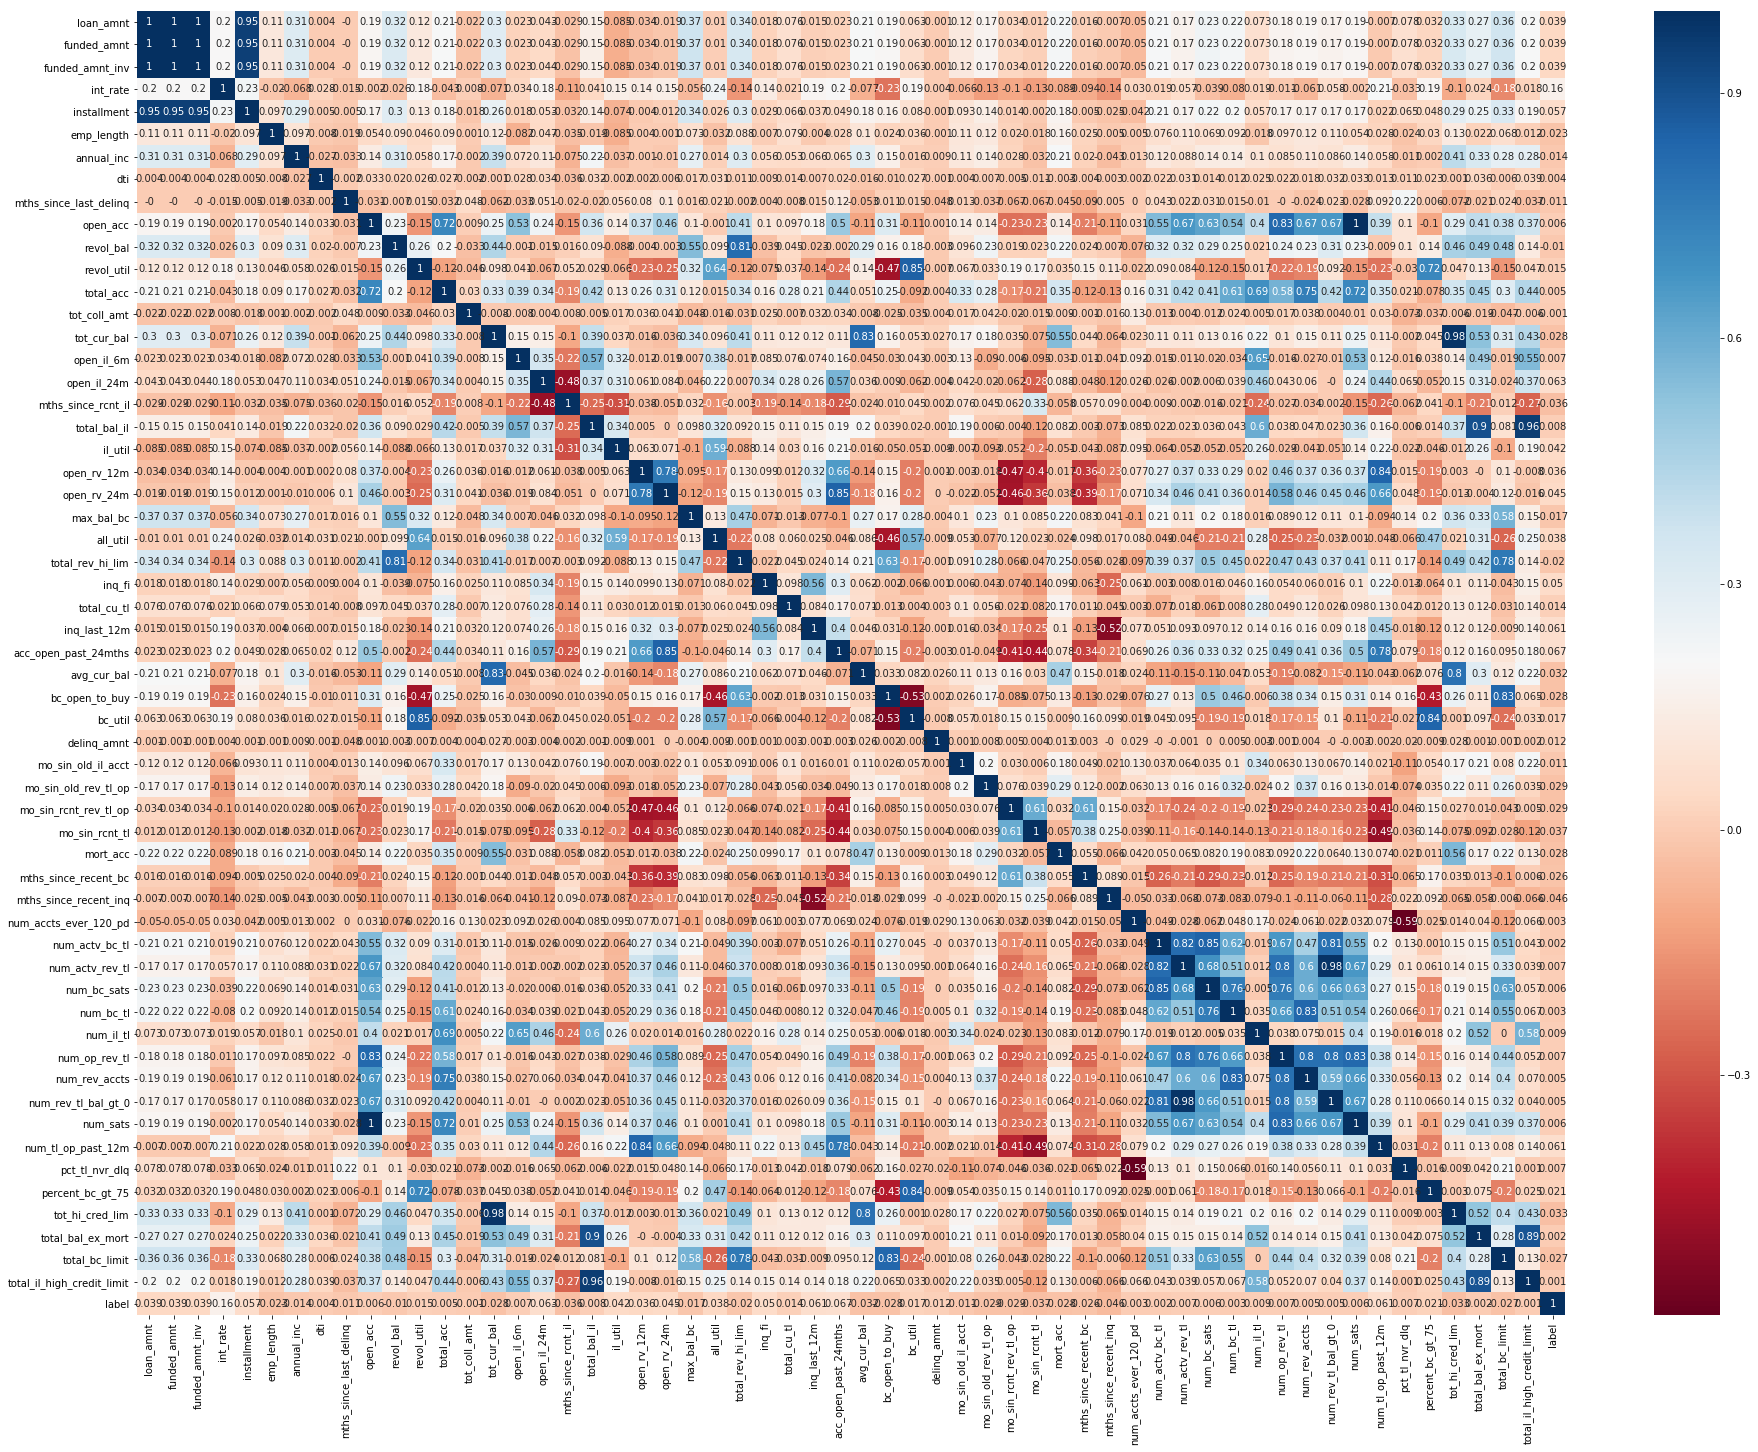

In [26]:
df_clean['label'] = y
plt.figure(figsize = (32, 24))
sns.heatmap(df_clean.corr().round(3), annot = True, cmap = 'RdBu')
df_clean.drop('label', axis = 1, inplace = True)

### 数据分布可视化

In [27]:
len(df_clean.select_dtypes(exclude = ['object']).columns)

57

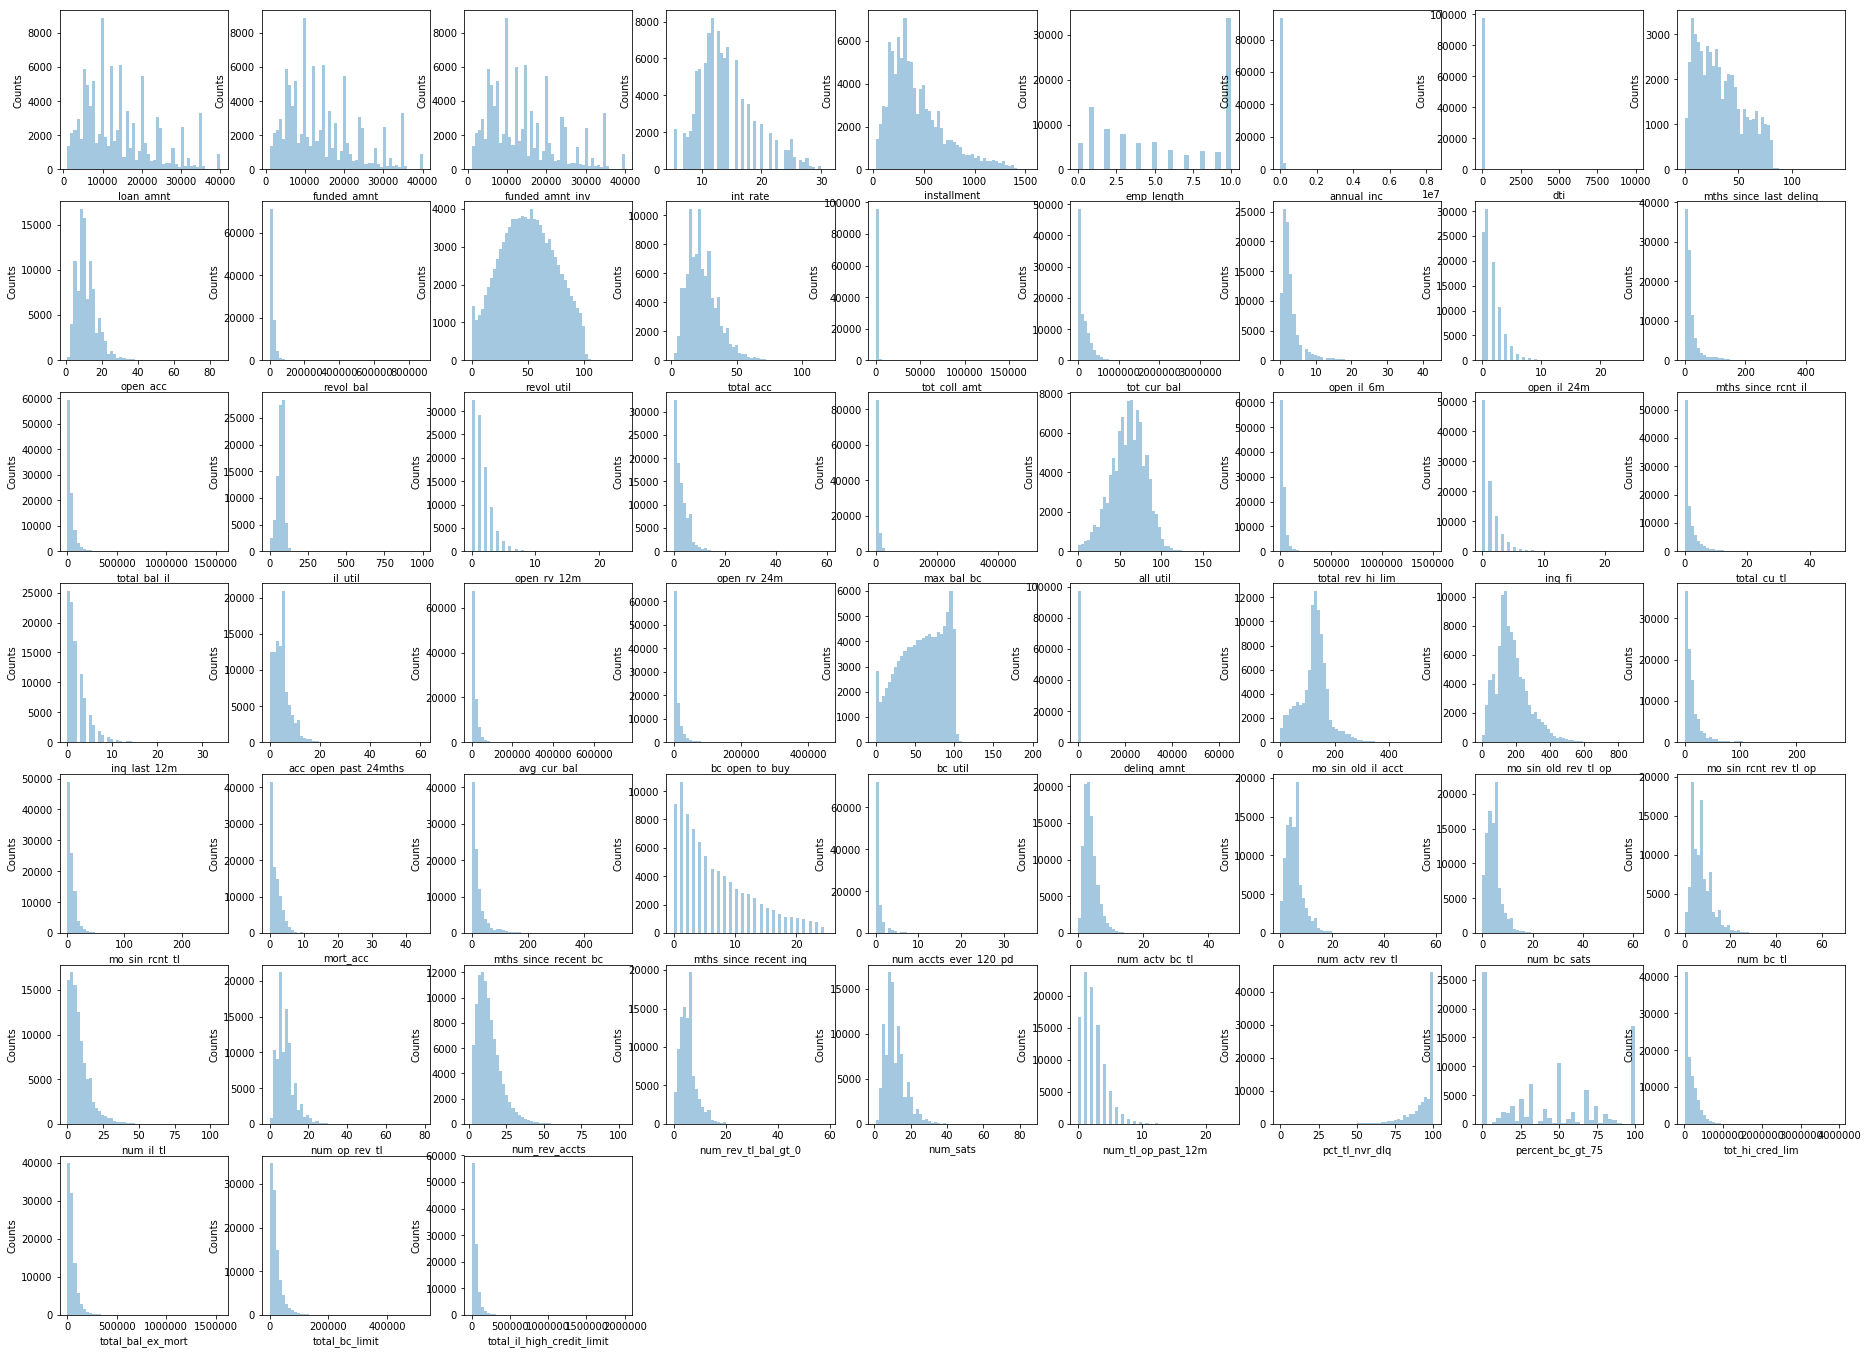

In [28]:
k = 0
plt.figure(figsize = (32, 24))
for col in df_clean.select_dtypes(exclude = ['object']).columns:
    k += 1
    plt.subplot(7, 9, k)
    plt.ylabel('Counts')
    sns.distplot(df_clean[col].dropna(), kde = False)

### 剔除相关性太高的特征

In [29]:
cor = df_clean.select_dtypes(exclude = ['object']).corr()
cor.loc[ : , : ] = np.tril(df_clean.corr().round(5), k = -1)
cor = cor.stack()
print(cor)
cor_set = set()
for index in cor[(cor > 0.8) | (cor < -0.8)].index:
    cor_set.add(index[0])
for col in cor_set:
    df_clean.drop(col, axis = 1, inplace = True)

loan_amnt                   loan_amnt                     0.00000
                            funded_amnt                   0.00000
                            funded_amnt_inv               0.00000
                            int_rate                      0.00000
                            installment                   0.00000
                            emp_length                    0.00000
                            annual_inc                    0.00000
                            dti                           0.00000
                            mths_since_last_delinq        0.00000
                            open_acc                      0.00000
                            revol_bal                     0.00000
                            revol_util                    0.00000
                            total_acc                     0.00000
                            tot_coll_amt                  0.00000
                            tot_cur_bal                   0.00000
          

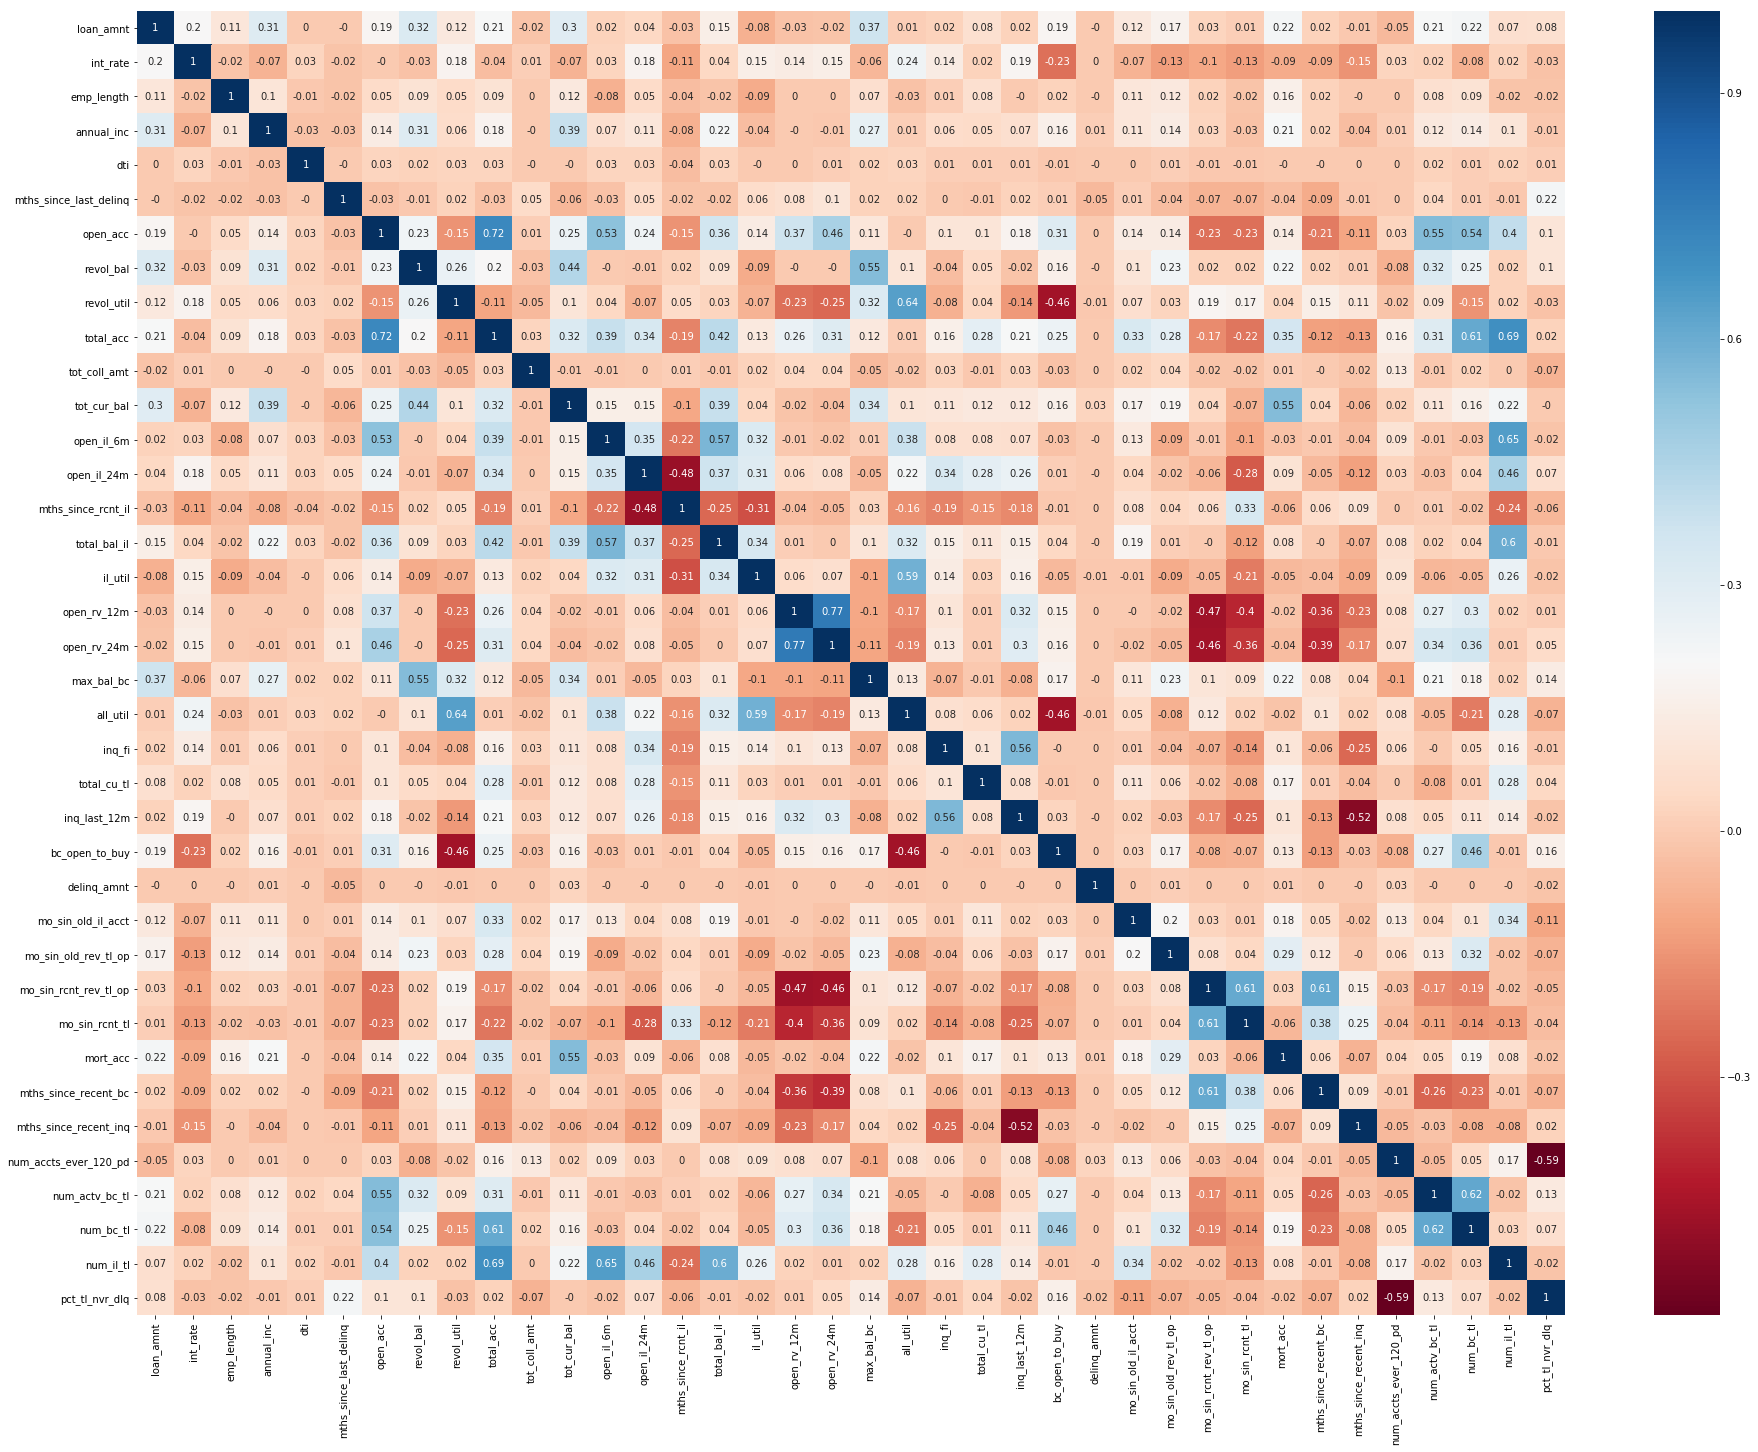

In [30]:
plt.figure(figsize = (32, 24))
sns.heatmap(df_clean.select_dtypes(exclude = ['object']).corr().round(2), annot = True, cmap = 'RdBu')

## object型数据分析

### 剔除取值过多的object型特征

In [31]:
object_list = []
object_col = []
for col in df_clean.select_dtypes(include = 'object').columns:
    object_list.append((col, len(df_clean[col].unique())))
    object_col.append(col)
for i in sorted(object_list, key = lambda x: x[1], reverse = True):
    print(i)
    if i[1] >= 50:
        object_list.remove(i)
        object_col.remove(i[0])
        df_clean.drop(i[0], axis = 1, inplace = True)

('emp_title', 36958)
('zip_code', 873)
('earliest_cr_line', 614)
('addr_state', 50)
('home_ownership', 4)
('verification_status', 3)
('application_type', 3)
('pymnt_plan', 2)
('initial_list_status', 2)


In [32]:
len(df_clean.select_dtypes(include = ['object']).columns)

5

### 数据分布可视化

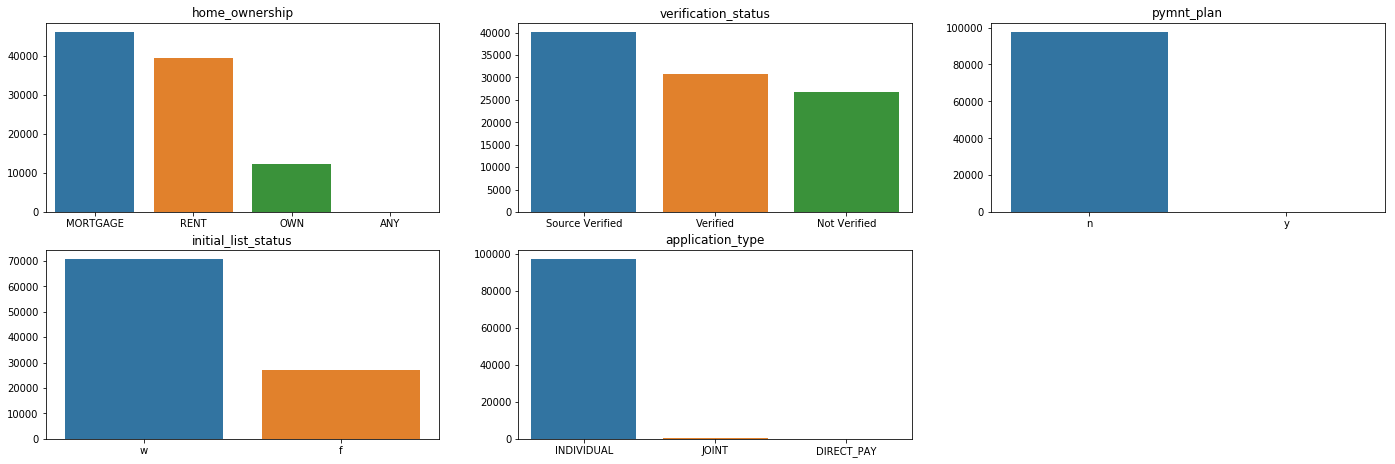

In [33]:
df_clean_object = df_clean.select_dtypes(include = ['object']).copy()
df_clean_object.fillna('missing', inplace = True)

k = 0
plt.figure(figsize = (24, 16))
for col in df_clean_object.columns:
    val = df_clean_object[col].value_counts()
    k += 1
    plt.subplot(4, 3, k)
    names = list(val.index)
    counts = list(val.values)
    data = pd.DataFrame({'names': names, 'counts': counts})
    plt.title(col)
    sns.barplot(x = names, y = counts, data = data)

In [0]:
df_clean.drop(['application_type', 'pymnt_plan'], axis = 1, inplace = True)

## 总体缺失数据的相关情况

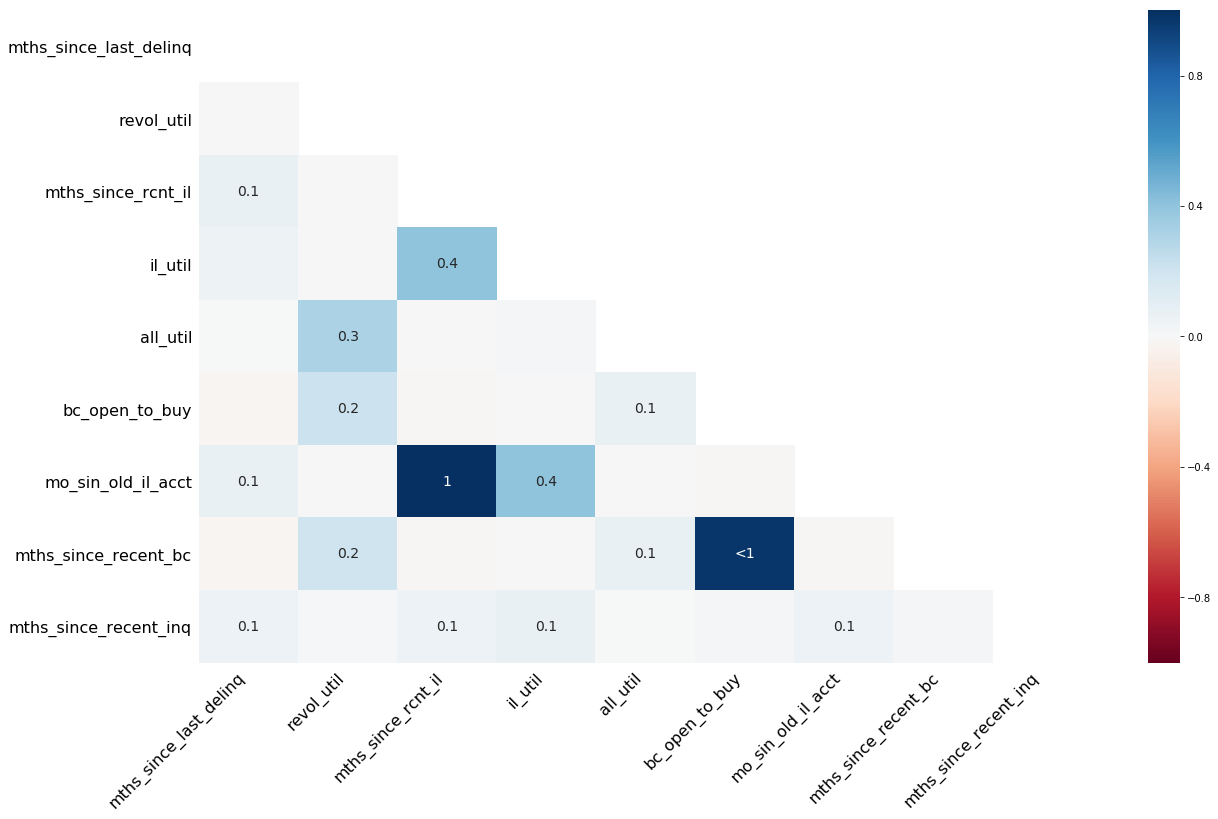

In [35]:
import missingno as msno

missing_col = []
for col in df_clean.columns:
    if len(df_clean[col][df_clean[col].isnull()].index):
        missing_col.append(col)
msno.heatmap(df = df_clean[missing_col])

# 特征处理

### 根据缺失情况构建新特征

In [0]:
df_clean['col_miss_1'] = np.zeros(df_clean.shape[0])
df_clean['col_miss_2'] = np.zeros(df_clean.shape[0])

df_clean.loc[df_clean['mo_sin_old_il_acct'].isnull(), 'col_miss_1'] += 1
df_clean.loc[df_clean['mths_since_rcnt_il'].isnull(), 'col_miss_1'] += 1
df_clean.loc[df_clean['mths_since_recent_bc'].isnull(), 'col_miss_2'] += 1
df_clean.loc[df_clean['bc_open_to_buy'].isnull(), 'col_miss_2'] += 1

### 字符型数据Onehotencoding

In [0]:
df_clean = pd.get_dummies(df_clean)

### 数值型特征填充空值

In [0]:
from sklearn.impute import SimpleImputer as imputer

In [0]:
impute = imputer(strategy = 'mean')
df_clean.iloc[ :, : ] = impute.fit_transform(df_clean)

In [40]:
df_clean.head()

,loan_amnt,int_rate,emp_length,annual_inc,dti,mths_since_last_delinq,open_acc,revol_bal,revol_util,total_acc,tot_coll_amt,tot_cur_bal,open_il_6m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,bc_open_to_buy,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_tl,num_il_tl,pct_tl_nvr_dlq,col_miss_1,col_miss_2,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_f,initial_list_status_w
0,15000.0,13.99,2.0,55000.0,23.78,7.000000,22.0,21345.0,57.8,43.0,0.0,140492.0,10.0,3.0,11.0,119147.0,101.0,3.0,4.0,14612.0,83.0,1.0,6.0,0.0,9645.0,0.0,157.0,248.0,4.0,4.0,0.0,4.0,22.000000,0.0,5.0,7.0,25.0,100.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,2600.0,8.99,3.0,35000.0,6.73,33.275346,14.0,720.0,1.4,24.0,0.0,19497.0,7.0,1.0,13.0,18777.0,92.0,0.0,2.0,383.0,27.0,1.0,0.0,1.0,49677.0,0.0,84.0,61.0,13.0,13.0,0.0,24.0,1.000000,0.0,4.0,8.0,14.0,100.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,32200.0,21.49,10.0,65000.0,11.71,33.275346,17.0,11987.0,48.1,34.0,0.0,173513.0,2.0,3.0,13.0,12947.0,82.0,2.0,2.0,6087.0,61.0,7.0,0.0,5.0,2666.0,0.0,128.0,286.0,3.0,3.0,3.0,32.0,0.000000,0.0,3.0,10.0,7.0,100.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,10000.0,11.49,10.0,55900.0,26.21,33.275346,15.0,17209.0,53.1,62.0,1393.0,38085.0,2.0,2.0,3.0,20876.0,57.0,5.0,5.0,7958.0,55.0,0.0,1.0,3.0,4762.0,0.0,252.0,114.0,1.0,1.0,1.0,1.0,2.000000,0.0,2.0,7.0,28.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,6000.0,13.49,5.0,33000.0,19.05,33.275346,3.0,4576.0,95.3,11.0,0.0,15393.0,1.0,1.0,8.0,10817.0,85.0,0.0,0.0,2658.0,88.0,0.0,0.0,0.0,224.0,0.0,128.0,242.0,44.0,8.0,0.0,118.0,6.637867,0.0,2.0,6.0,2.0,100.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


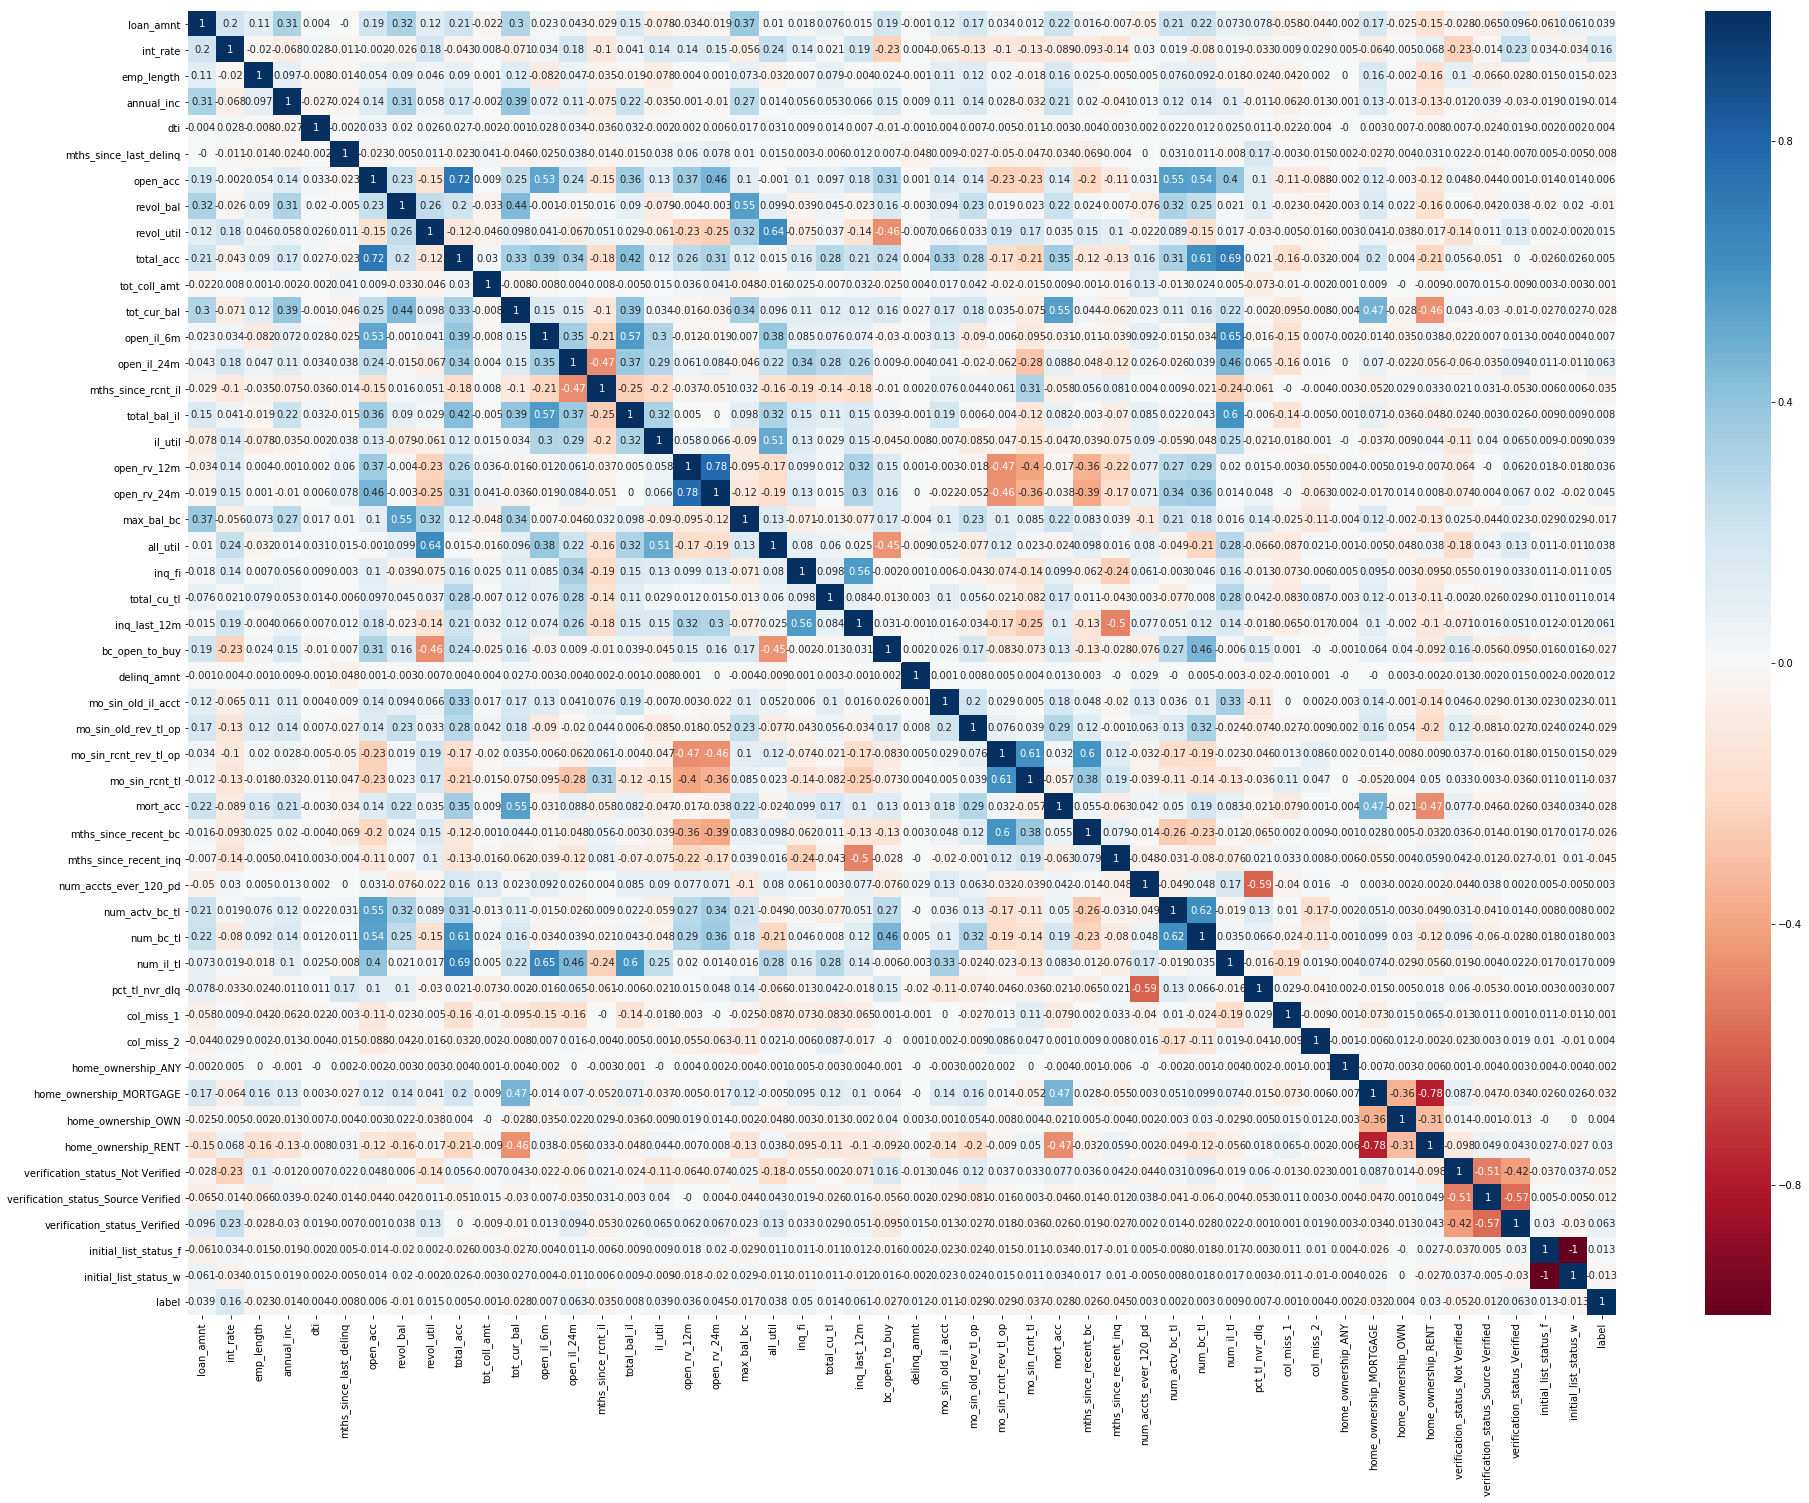

In [41]:
df_clean['label'] = y
plt.figure(figsize = (32, 24))
sns.heatmap(df_clean.corr().round(3), annot = True, cmap = 'RdBu')
df_clean.drop('label', axis = 1, inplace = True)

In [42]:
len(y[y == 0]) / len(y[y == 1])

17.78715631609306

In [43]:
y.sum() / len(y)

0.053227853283117736

In [0]:
from sklearn.model_selection import train_test_split as tts

In [0]:
X_train, X_test, y_train, y_test = tts(df_clean, y, test_size = 0.2, random_state = 2019, stratify = y)

In [0]:
import xgboost as xgb
from sklearn.metrics import recall_score as recall, roc_auc_score as auc, log_loss, roc_curve

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
145        0.703767       0.002011       0.693009      0.005584
146        0.703963       0.001975       0.693151      0.005625
147        0.704031       0.002034       0.693244      0.005675
148        0.704122       0.001985       0.693541      0.005925
149        0.704270       0.002038       0.693651      0.005941


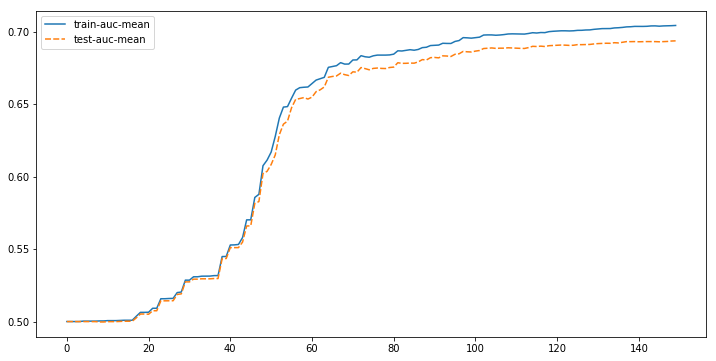

In [190]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

param = {'verbosity': 1,
         'objective': 'binary:logistic',
         'stratified': True,
         'max_depth': 1,
         'subsample': 0.8,
         'eta': 0.1,
         'gamma': 0,
         'lambda': 4,
         'alpha': 0,
         'scale_pos_weight': 20,
         'min_child_weight': 5,
         'max_delta_step': 0.5,
         'base_score': 0.05,
         'colsample_bytree': 0.6,
         'colsample_bynode': 0.4,
         'colsample_bylevel': 0.4,
         'seed': 2019,
         'eval_metric': 'auc',
         'nfold': 4}
num_round = 150
pred_cv = xgb.cv(param, dtrain, num_round, nfold = 4, verbose_eval = False, seed = 2019)
print(pred_cv.tail())

plt.figure(figsize = (12, 6))
sns.lineplot(data = pred_cv.drop(['train-auc-std', 'test-auc-std'], axis = 1))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


AUC is  0.6973749792324307
Recall_rate is  0.8461538461538461
Logloss is 0.6856023147092762
KS系数为 0.4297225452733012


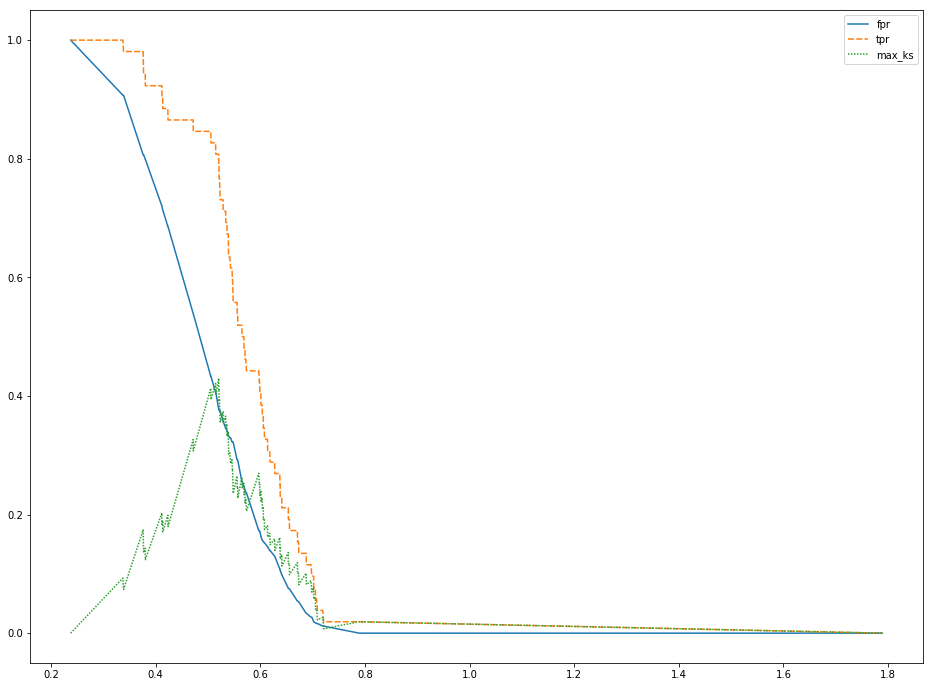

In [189]:
dtrain = xgb.DMatrix(X_train,  y_train)
dtest = xgb.DMatrix(X_test, y_test)

param = {'verbosity': 1,
         'objective': 'binary:logistic',
         'stratified': True,
         'max_depth': 1,
         'subsample': 0.8,
         'eta': 0.1,
         'gamma': 0,
         'lambda': 4,
         'alpha': 0,
         'scale_pos_weight': 20,
         'min_child_weight': 5,
         'max_delta_step': 0.5,
         'base_score': 0.05,
         'colsample_bytree': 0.6,
         'colsample_bynode': 0.4,
         'colsample_bylevel': 0.4,
         'seed': 2019,
         'eval_metric': 'auc',
         'nfold': 4}
num_round = 150

bst = xgb.train(param, dtrain, num_round)

pred = bst.predict(dtest)

y_pred = pred.copy()
y_pred[y_pred > 0.5] = 1
y_pred[y_pred != 1] = 0

print('AUC is ', auc(y_test, y_pred))
print('Recall_rate is ', recall(y_test, y_pred))
print('Logloss is', log_loss(y_test, pred))

fpr, tpr, threadshold = roc_curve(y_test, pred)
ks = max(tpr - fpr)
print('KS系数为', ks)

plt.figure(figsize = (16,12))
sns.lineplot(data = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'max_ks': tpr - fpr}, index = threadshold))

In [50]:
'''
import pandas_profiling

df_clean.profile_report(
    style = {'full_width': True}, 
    plot ={'histogram':{'bayesian_blocks_bins': False}})

'''

"\nimport pandas_profiling\n\ndf_clean.profile_report(\n    style = {'full_width': True}, \n    plot ={'histogram':{'bayesian_blocks_bins': False}})\n\n"